# Market Risk project

FOURREAU Mathis

GAUSSIN Natacha

ESILV IF3

# Library and dataset importation

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.integrate import cumulative_trapezoid as cumtrapz

In [45]:
# Load the dataset
df = pd.read_csv("Natixis.csv", sep = ";")

# Transform the date column to datetime and sort the dataframe by date
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df.sort_values("date", inplace = True)

# Transform the value column to numeric
df["value"] = (df["value"].astype(str).str.replace(",", ".", regex=False))
df["value"] = pd.to_numeric(df["value"], errors="coerce")

# display the dataframe
df

,date,value
0,2015-01-02,5.621
1,2015-01-05,5.424
2,2015-01-06,5.329
3,2015-01-07,5.224
4,2015-01-08,5.453
...,...,...
1018,2018-12-21,4.045
1019,2018-12-24,4.010
1020,2018-12-27,3.938
1021,2018-12-28,4.088


In [46]:
# Compute the returns
df["return"] = df["value"] / df["value"].shift(1) - 1

# QUESTION : EST CE QUE LES RETURNS SONT BONS ICI CAR LES VARIATIONS DE TEMPS NE SONT PAS CONSTANTES ??

## Question A (Ex2, part of Q1 and of Q2 of TD1)

**a** – From the time series of the daily prices of the stock Natixis between January 2015 and December 2016, provided with TD1, estimate a historical VaR on price returns at a one-day horizon for a given probability level (this probability is a parameter which must be changed easily). You must base your VaR on a non-parametric distribution (biweight Kernel, that is $K$ is the derivative of the logistic function $x \mapsto \frac{15}{16}(1-x^2)^2 \mathbb{1}_{|x| \leq 1}$).

In [47]:
# Extract returns for the years prior to 2017 (2015 and 2016)
returns_2015_2016 = df[df["date"] < "2017"].dropna().loc[:, "return"]
returns_2015_2016

1     -0.035047
2     -0.017515
3     -0.019704
4      0.043836
5     -0.020723
         ...   
508   -0.008118
509    0.000744
510   -0.000186
511   -0.009481
512    0.006006
Name: return, Length: 512, dtype: float64

### First step: Estimation of the kernel density 
$$\hat{f}(x) = \frac{1}{nh}\sum_{i=1}^{n} K\left(\frac{x - X_i}{h}\right)$$ with $$K(x) = \frac{15}{16}(1-x^2)^2 \mathbb{1}_{|x| \leq 1}$$

The following functions are used to generate the kernel density for a wide range of x. This will be usefull to choose the value of h.

In [48]:
#def K(x)
def K(x):
    K_tab = []
    for i in x:
        if i <= 1 and i >= -1:
            K_tab.append((15/16) * (1 - i**2)**2)
        else:
            K_tab.append(0)
    return K_tab

# def f_hat(x, h, tab_returns)
def f_hat(x, h, tab_returns):
    return sum(K((x - tab_returns) / h)) / (len(tab_returns) * h)

# estimate 1000 times f_hat
def estimate_f_hat(tab_returns, h, nb_estimations = 1000):
    x_tab = np.linspace(min(tab_returns) - 5*h, max(tab_returns) + 5*h, nb_estimations)
    f_hat_tab = []
    for x in x_tab:
        f_hat_tab.append(f_hat(x, h, tab_returns))

    return f_hat_tab, x_tab

### Second Step : Choice of h

**Scott’s rule**
$$
h_{\text{Scott}} = \sigma\, n^{-1/5}
$$

**Silverman’s rule**
$$
h_{\text{Silverman}} = 0.9\, \min\!\left(\sigma,\; \frac{\mathrm{IQR}}{1.34}\right) n^{-1/5}
$$



# A FAIRE:
- calculer h via les 2 methodes
- tracer les kernel density pour ces 2 h (et dautres comme déjà fait), selectioner le h avec la courbe la plus smooth ou celui obtenu via la Silverman's rule (en général plus robuste) 

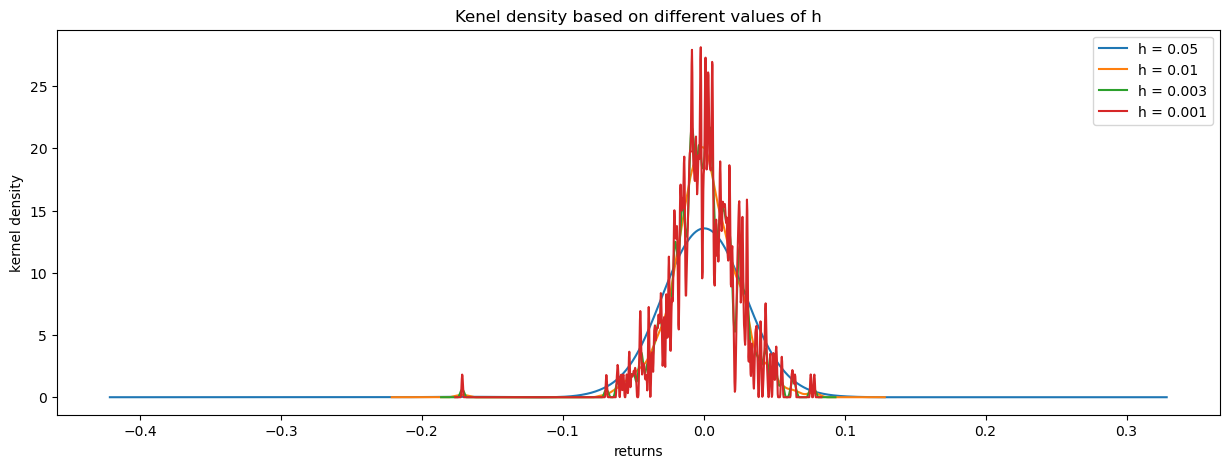

In [49]:
h_tab = [0.05, 0.01, 0.003, 0.001]

plt.figure(figsize=(15, 5))
for h in h_tab:
    f_hat_tab, x_tab = estimate_f_hat(returns_2015_2016, h)
    plt.plot(x_tab, f_hat_tab, label = f"h = {h}")

plt.xlabel("returns")
plt.ylabel("kernel density")
plt.title("Kenel density based on different values of h")
plt.legend()
plt.show()

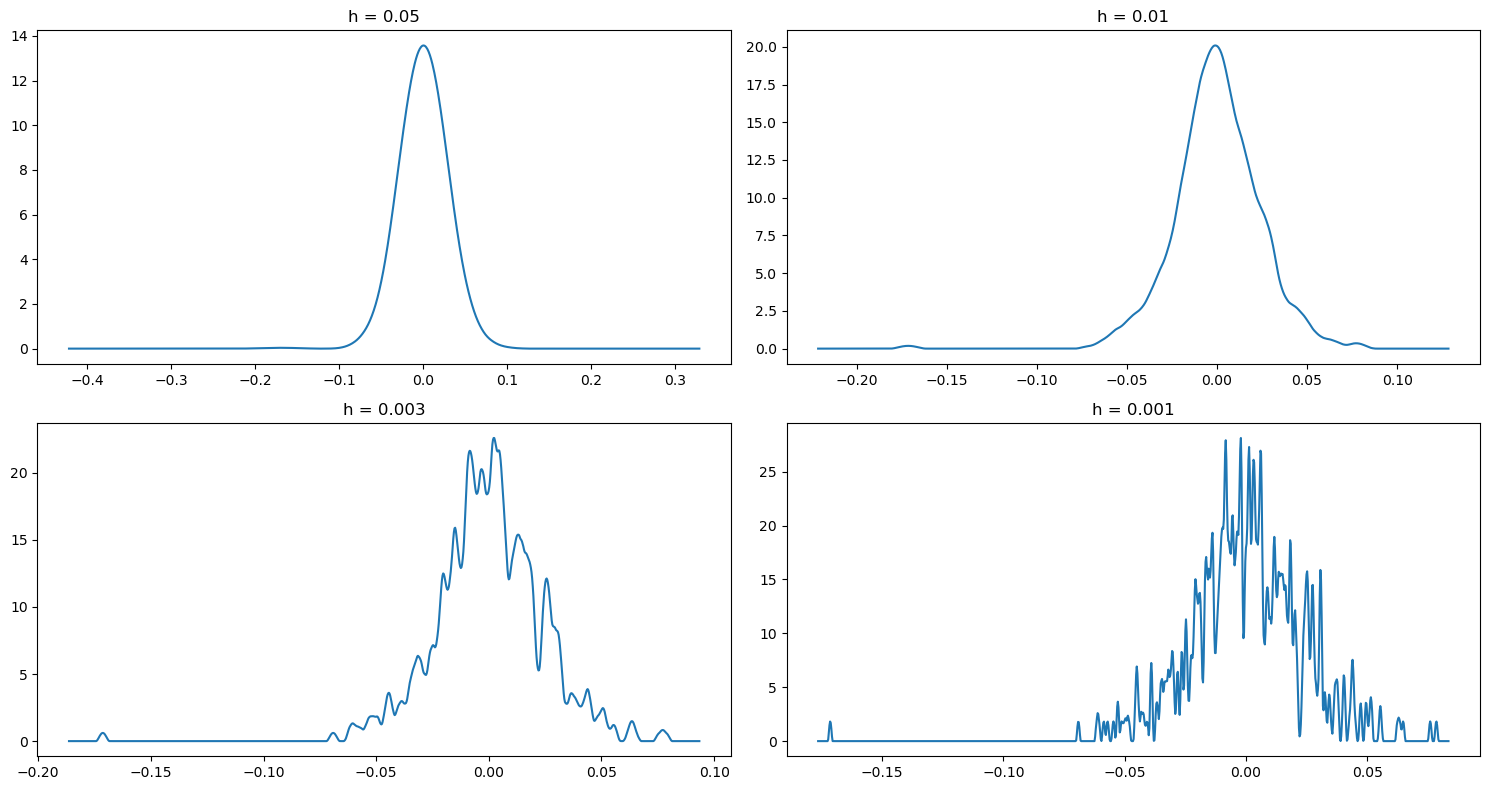

In [50]:
h_tab = [0.05, 0.01, 0.003, 0.001]
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
h = 0
for i in (0, 1):
    for j in (0, 1):
        f_hat_tab, x_tab = estimate_f_hat(returns_2015_2016, h_tab[h])
        axes[i, j].plot(x_tab, f_hat_tab)
        axes[i, j].set_title(f"h = {h_tab[h]}")
        h+=1

plt.tight_layout()
plt.show()
        

**Observations**
When h = 0.001 the density is too noisy, whereas when h = 0.01 and h = 0.05 the density is too smooth. That is why we choose h = 0.003.

### 3rd Step : Define the CDF of K and use

$$\hat{F}(x) = \frac{1}{n}\sum_{i=1}^{n} \mathcal{K}\left(\frac{x - X_i}{h}\right)$$

To define $\mathcal{K}$ we have to primitive K.

$$
\mathcal{K}(u) = \begin{cases}
0 & \text{si } u < -1 \\[0.5em]
\frac{1}{2} + \frac{15}{16}\left(u - \frac{2u^3}{3} + \frac{u^5}{5}\right) & \text{si } -1 \leq u \leq 1 \\[0.5em]
1 & \text{si } u > 1
\end{cases}
$$

In [51]:
#def K_cdf(x):
def K_cdf(x):
    if x <= 1 and x >= -1:
        return (15/16)*(x - 2*x**3/3 + x**5/5 + 8/15)
    elif x < -1:
        return 0.0
    else:
        return 1.0

def K_cdf_vector(u_tab):
    return [K_cdf(u) for u in u_tab]

def F_hat(x, h, returns_tab):
    u_tab = (x-returns_tab)/h
    return sum(K_cdf_vector(u_tab)) / len(returns_tab)

def Series_F_Hat(h, returns_tab, x_tab):
    return [F_hat(x, h, returns_tab) for x in x_tab]

def ComputeVaR(h, returns_tab, alpha, nb_estimations=1000):
    x_tab = np.linspace(min(returns_tab) - 5*h, max(returns_tab) + 5*h, nb_estimations)
    F_hat_tab = Series_F_Hat(h, returns_tab, x_tab)
    i = 0
    while i < len(F_hat_tab):
        if F_hat_tab[i] >= alpha:
            return x_tab[i]
        i+=1

    return x_tab[len(x_tab) - 1]

In [52]:
h = 0.003
alpha = 0.01
VaR = ComputeVaR(h, returns_2015_2016, alpha)
print("The historical Value at Risk base on a non-parametric distribution for level alpha,", alpha, " is equal to ", VaR)

The historical Value at Risk base on a non-parametric distribution for level alpha, 0.01  is equal to  -0.05750841439123988


**b – Which proportion of price returns between January 2017 and December 2018 does exceed the VaR
threshold defined in the previous question? Do you validate the choice of this non-parametric VaR?**


In [53]:
returns_2017_2018 = df[df["date"] >= "2017"].dropna().loc[:, "return"]
returns_2017_2018

513     0.007463
514     0.040741
515     0.003737
516    -0.008155
517    -0.005719
          ...   
1018   -0.001481
1019   -0.008653
1020   -0.017955
1021    0.038090
1022    0.007583
Name: return, Length: 510, dtype: float64

Simply find the proportion of returns < to the VaR find and compare with the alpha. Mentionne the word coverage.

In [54]:
def Proportion(df, VaR):
    return df[df < VaR].count() / df.count()

prop = Proportion(returns_2017_2018, VaR)

print("the proportion of returns that exceed the VaR threshold is", prop)

if prop > alpha:
    print("VaR underestimates the risk")
elif prop == alpha:
    print("VaR is correct")
else:
    print("VaR overestimates the risk")

the proportion of returns that exceed the VaR threshold is 0.00196078431372549
VaR overestimates the risk


## Question B (Ex2, Q5 of TD2)

**Calculate the expected shortfall for the VaR calculated in question A. How is the result, compared to the VaR?**

In [55]:
def expectedShortfall(returns_tab, VaR):
    return np.mean([l for l in returns_tab if l <= VaR])

ES_alpha = expectedShortfall(returns_2015_2016, VaR)

print("The expected shortfall is ", ES_alpha)

The expected shortfall is  -0.08422676461030879


## Question C (Ex2, Q1 and Q2 of TD3)

With the dataset provided for TD1 on Natixis prices, first calculate daily returns. You will then analyse
these returns using a specific method in the field of the EVT.

**a – Estimate the GEV parameters for the two tails of the distribution of returns, using the estimator of
Pickands. What can you conclude about the nature of the extreme gains and losses?**


In [56]:
def pickandsEstimator(returns_tab):
    returns_tab.sort()
    N = len(returns_tab)
    k = np.floor(np.log(N))
    # starts from 0 so n is :
    n = N - 1 
    e = np.log((returns_tab[int(n - k + 1)] - returns_tab[int(n - 2 * k + 1)]) / (returns_tab[int(n - 2 * k + 1)] - returns_tab[int(n - 4 * k + 1)]))
    e /= np.log(2)
    return e

def naturePickands(e):
    if e > 0:
        print("Heavy tails : GEV is of Fréchet kind")
    elif e == 0:
        print("Light tails : GEV is of Gumbel kind")
    else:
        print("Bounded support : GEV is of Weibull kind")

# loss
loss = list(df[df["return"] < 0]["return"] * -1)
e_loss = pickandsEstimator(loss)
print("e_loss :", e_loss)
naturePickands(e_loss)

# gain
gain = list(df[df["return"] > 0]["return"])
e_gain = pickandsEstimator(gain)
print("e_gain :", e_gain)
naturePickands(e_gain)

e_loss : -0.5089715779341932
Bounded support : GEV is of Weibull kind
e_gain : 0.5772338569463368
Heavy tails : GEV is of Fréchet kind


**b – Calculate the value at risk based on EVT for various confidence levels, with the assumption of iid
returns.**


**Course formula**

$$
\mathrm{VaR}(p)
=
\frac{\left(\dfrac{k}{n(1-p)}\right)^{\xi^{p}} - 1}{1 - 2^{-\xi^{p}}}
\left(
X_{n-k+1:n} - X_{n-2k+1:n}
\right)
+ X_{n-k+1:n}.
$$

From the course, in the EVT framework, we have
$$
k(n) = np + o(\sqrt{n}),
$$
(see p. 184).


In [83]:
def ComputeVaRp(returns_tab, e, p):
    returns_tab.sort()
    N = len(returns_tab)
    #k = np.floor(np.log(N))
    k = np.floor(N*p)
    # starts from 0 so n is :
    n = N - 1 
    multi = (k / (n * (1.0 - p))) ** e - 1.0
    multi /= (1.0 - 2.0**(-e))

    return multi * (returns_tab[int(n - k + 1)] - returns_tab[int(n - 2 * k + 1)]) + returns_tab[int(n - k + 1)]

p_tab = [0.005, 0.01, 0.02, 0.05]
for p in p_tab:
    print(f"for p = {p} and the estimator = {round(e_loss, 4)} we have VaR(p) = {round(ComputeVaRp(loss, e_loss, p), 4)}")

for p = 0.005 and the estimator = -0.509 we have VaR(p) = -0.2174
for p = 0.01 and the estimator = -0.509 we have VaR(p) = -0.076
for p = 0.02 and the estimator = -0.509 we have VaR(p) = -0.0831
for p = 0.05 and the estimator = -0.509 we have VaR(p) = -0.0617


**Question D (Ex2, Q5 of TD4)**

With the dataset and the framework provided for TD4, estimate all the parameters of Bouchaud's price
impact model. Comment the obtained values. Is this model well specified?

In [59]:
df_TD4 = pd.read_excel("Dataset TD4.xlsx")
df_TD4_grouped = df_TD4.rename(columns={
    "transaction date (1=1day=24 hours)": "t",
    "bid-ask spread": "spread",
    "volume of the transaction (if known)": "volume",
    "Sign of the transaction": "sign",
    "Price (before transaction)": "price"
})

df_TD4_grouped.sort_values(by = "t", inplace = True)

df_TD4_grouped["t_bin"] = (df_TD4_grouped["t"] // 0.02) * 0.02
df_TD4_grouped["t_bin"] = df_TD4_grouped["t_bin"]
df_TD4_grouped = df_TD4_grouped.groupby("t_bin").agg({
    "spread": "last", 
    "volume": "last",
    "sign": "last",
    "price": "last"
}).reset_index()

**Backward definition of the price: the price is the sum of past impacts (Bouchaud):**

$$p_t = p_{-\infty} + \sum_{s=-\infty}^{t-1} G(t-s)\varepsilon_s S_s V_s^r$$

where:

- $S$ is the bid-ask spread;

- $\varepsilon$ is -1 or 1 depending on whether the transaction is a buy (price = ask) or a sell (price = bid) on the market;

- $V$ is the volume of the transaction, with $r$ close to zero to have a concave function of the volume;

- $G$ is a function worth 0 on $\mathbb{R}^-$, which can be interpreted as the impact of a single order. A statistical study on long-term correlation can allow this function to be fixed, in the form, for example, of a decreasing power function.


Parameters to estimate:
- the function G
- the exposant r

### Estimation of G

For this part every elements come from 3 differents articles writed by Jean-Philippe Bouchaud. In these articles we took methods, formulas, but also exemples of estimated parameters to check the coherence of our estimations.

### References

- Bouchaud, J.-P. (2009). *Price Impact*.

- Taranto, D. E., Bormetti, G., Bouchaud, J.-P., Lillo, F., & Tóth, B. (2016).  
  *Linear models for the impact of order flow on prices*.

- Bouchaud, J.-P., Gefen, Y., Potters, M., & Wyart, M. (2004).  
  *Fluctuations and response in financial markets: the subtle*


The model from the course isn't really mentionned in the litterature or at least we don't find it, however it exist an almost similar expression in (2009, 4.3) where a non-linear modele is introduce.
$$
p_T = p_{-\infty} + \lambda \sum_{n=-\infty}^{N-1} G(N - n)\,\varepsilon_n\, v_n^{\psi}
$$
The only change is the presence of $\lambda$, which is inversely proportional to market liquidity. 
In practice, $\lambda$ implicitly captures liquidity effects such as the bid–ask spread, which is in the course formula but not explicitly included in this formula. 
This formulation can be used to estimate the impact kernel $G$ and the exponent $\psi$ (denoted $r$ in the course notation).

First from (2009), 
$$
G(\ell) = G(1) + \sum_{n=1}^{\ell} \mathcal{G}(n)
$$

where 
$$
\mathcal{G}(\ell) = -(2\rho - 1)\,G(1)\,\lambda_{\ell}
$$

p is the probability that two successive transaction have the same sign, p is usually taken between [0.6,0.7]. $\lambda_{l}$ can be obtain with another quantitie that we are able to compute,

$$
C_0(\ell) = \langle \varepsilon_{n+\ell}\varepsilon_n \rangle - \langle \varepsilon_n \rangle^2
\;\simeq\; \frac{C_0}{\ell^{\gamma}}, \qquad \text{for } \ell \gg 1
$$
$$
\log C_0(\ell) \;\simeq\; \log C_0 - \gamma \log \ell
$$

and if this approximation holds,
$$
\lambda_\ell \sim \ell^{(\gamma - 3)/2}
$$



### First Step: Estimate $\gamma$ with $C_0$

In [60]:
eps = df_TD4["Sign of the transaction"].to_numpy()

In [61]:
#Compute C_0
def C_0(eps_tab, l_min, l_max):
    
    C0 = np.zeros(l_max - l_min)
    mu = np.mean(eps_tab)
    for l in range(l_min, l_max):
        C0[l-l_min] = np.mean(eps_tab[l:]*eps_tab[:-l]) - mu**2
    return C0

l_min = 20
l_max = 50

C0 = C_0(eps, l_min, l_max)

mask = C0 > 0 #To be able to apply log() and find gamma
C0_reg = C0[mask] 
l_vect = np.arange(l_min, l_max)[mask]

l_vect_log = np.log(l_vect)
C0_reg_log = np.log(C0_reg)

coeffs = np.polyfit(l_vect_log, C0_reg_log, 1)
gamma_hat = -coeffs[0]
intercept = coeffs[1]
print(f"Estimated C0 = {np.exp(intercept)}")
print(f"Estimated gamma = {gamma_hat}")


Estimated C0 = 0.07464905158260039
Estimated gamma = 0.3652812433996198


##### Visualisation of the log-log relation

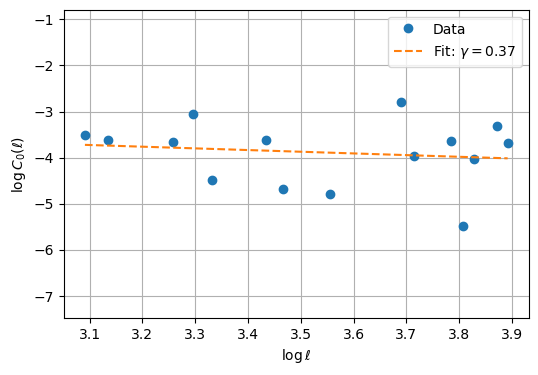

In [62]:
plt.figure(figsize=(6,4))
plt.plot(l_vect_log, C0_reg_log, 'o', label="Data")
plt.plot(l_vect_log, intercept - gamma_hat * l_vect_log, '--',
         label=rf"Fit: $\gamma={gamma_hat:.2f}$")

plt.xlabel(r"$\log \ell$")
plt.ylabel(r"$\log C_0(\ell)$")

plt.ylim(C0_reg_log.min() - 2, C0_reg_log.max() + 2)

plt.legend()
plt.grid(True)
plt.show()


##### Discussion
This estimation does not have a high level of reliability, as we only use about 1,000 observations. 
In the papers by J.-P. Bouchaud, the estimations are based on millions of data points. 
However, they typically find values of $\gamma$ between 0.2 and 0.5. 
Our estimate, $\gamma \approx 0.37$, therefore is totally realistic.

### Second Step: Determine $\lambda_l$ and Compute $G(\ell)$

We obtained $\gamma$, therefore we can easely determine $\lambda_l$ with the opproximation presented above:
$$
\lambda_\ell \sim \ell^{(\gamma - 3)/2}
$$


In [63]:
def lambda_l(gamma,l):
    lambda_l = l**((gamma-3)/2)

And thus we can also compute $\mathcal{G}(\ell)$ and so $G(\ell)$ using the formulas presented above.

In [64]:
def Gs(l, p, G1, gamma):
    lambda_l = l**((gamma-3)/2)
    Gs_l = -(2*p-1)*G1*lambda_l
    return Gs_l

def G(G1, l, p, gamma):
    G_l = G1
    i = 1
    while i <= l:
        G_l += Gs(i, p, G1, gamma)
        i+=1
    return G_l

By convention we will take $G(1)=1$ ,this choice has no impact on the shape of $G(\ell)$ and on the value of the other parameters. the choice of $\rho$ is much harder, in fact we choose the highest p such that $G(\ell)$ is well defined (such that we observe something close to a decreasing power function), we did that because when 
$$
C(\ell) \underset{\ell \gg 1}{\sim} \ell^{-\gamma},
$$
already verified. Then,
$$
\rho \to 1^{-}.
$$



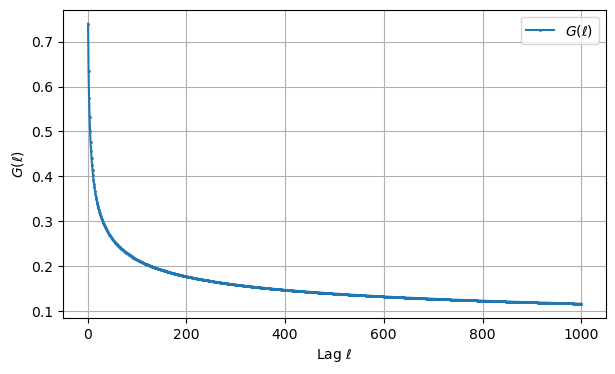

In [65]:
G1 = 1.0       
gamma = gamma_hat   
p = 0.63

L_max = 1000
lags = np.arange(1, L_max + 1)

G_vals = np.array([G(G1, l, p, gamma) for l in lags])

plt.figure(figsize=(7,4))
plt.plot(lags, G_vals, 'o-',markersize=1, label=r"$G(\ell)$")

plt.xlabel(r"Lag $\ell$")
plt.ylabel(r"$G(\ell)$")
plt.grid(True)
plt.legend()
plt.show()

### Approximate $G(\ell)$
Now that we have compute $G(\ell)$, we wan't to approximate it as a power decreasing function, how it's mentionned in the course. For that purpose we will use (2016):
$$
C(\ell) \sim \ell^{-\gamma} \;\Rightarrow\;
G(\ell) \sim \ell^{-\beta}, \qquad \beta = \frac{1 - \gamma}{2}, \quad \ell \gg 1.
$$

To obtain a more reliable estimation of $\beta$, we will estimate it in two different ways.
- First, by determining the slope of the log–log plot of $G(\ell)$ as a function of $\ell$ (for large $\ell$ ).
- Second, using the approximation $\beta = \frac{1 - \gamma}{2}$, which requires a Hurst exponent $H$ close to 0.5, a condition that we will verify.



#### Determining the slope of the log–log plot of $G(\ell)$ as a function of $\ell$

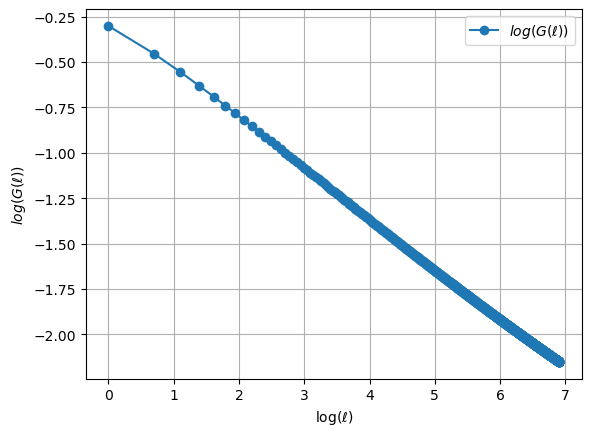

In [66]:
log_lags = np.log(lags)
log_G_vals = np.log(G_vals)

plt.plot(log_lags, log_G_vals, 'o-', label=r"$log(G(\ell))$")


plt.xlabel(r"log($\ell$)")
plt.ylabel(r"$log(G(\ell))$")
plt.grid(True, which="both")
plt.legend()
plt.show()

In [67]:
l_min = 100
mask = lags >= l_min

lags_filtered = lags[mask]
G_filtered = np.abs(G_vals[mask])

log_l = np.log(lags_filtered)
log_G = np.log(G_filtered)

coeffs = np.polyfit(log_l, log_G, 1)
intercept = coeffs[1]
beta_hat = -coeffs[0]

print(f"Estimated beta = {beta_hat:.3f}")


Estimated beta = 0.264


We find a $\beta$ of 0.264, we will visualize this relation.

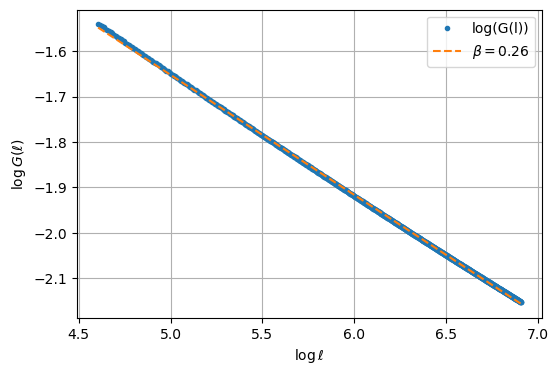

In [68]:
plt.figure(figsize=(6,4))
plt.plot(log_l, log_G, 'o',markersize=3, label="log(G(l))")
plt.plot(log_l, intercept - beta_hat * log_l, '--',
         label=rf"$\beta={beta_hat:.2f}$")
plt.xlabel(r"$\log \ell$")
plt.ylabel(r"$\log G(\ell)$")
plt.legend()
plt.grid(True)
plt.show()

We can see on this visualisation that the relation on the log-log plot is indeed very linear.

#### Using now the approximation $\beta = \frac{1 - \gamma}{2}$

This approximation from 2016 is derived from the original relation (2004):
$$
2H = 2 - 2\beta - \gamma
$$
where H is the Hurst exponent.

Therefore a condition (fluctuations are diffusive at long times (H = 1/2)), give us $\beta = \frac{1 - \gamma}{2}$. We will estimate the Hurst exponent to see if the condition is respected.


In [69]:
#Use of df_TD4_grouped to have constant duration for the increments
M2 = ((df_TD4_grouped["price"]- df_TD4_grouped["price"].shift(1)) * (df_TD4_grouped["price"] - df_TD4_grouped["price"].shift(1))).mean()
def ComputeM2_prime(df):
    m2_prime = 0.0

    for i in range (1, (len(df)-1) // 2 + 1):
        m2_prime += (df["price"].iloc[2*i] - df["price"].iloc[2*i-2]) * (df["price"].iloc[2*i] - df["price"].iloc[2*i-2])
    m2_prime /= (len(df)-1) // 2
    
    return m2_prime

M2_prime = ComputeM2_prime(df_TD4_grouped)
H_hat = np.log2(M2_prime/M2)/ 2
H_hat

0.5451525909483125

The H estimate is pretty close to 0.5 so we can use the relation $\beta = \frac{1 - \gamma}{2}$ but also the non simplified one, with the H estimated.

In [70]:
beta_hat2 = (1-gamma_hat)/2
print(beta_hat2)

beta_hat3 = (2 - 2*H_hat - gamma_hat)/2
print(beta_hat3)

0.3173593783001901
0.27220678735187764


These values are very close to the estimate of $\beta$ obtained with the first method. 
Therefore, for large $\ell$, we can approximate
$$
G(\ell) \sim \ell^{-\beta},
$$
with $\beta \approx 0.27$.


# A FAIRE (Mathis)
Estimer r

## Question E

# A FAIRE

- Bien rédiger cette question et faire la 3e correlation sur le même graph (SEK_CAD)
- Vérifier qu'il n'a pas d'erreur, car on nous demande d'observer si il y a un effet de Epps (la correlation augmente avec j qui augmente), on observe cela que sur une des deux devises, pas forcément un problème mais être sur.

In [71]:
df = pd.read_excel("Dataset TD5.xlsx", header=None)

In [72]:
df_gbp = df[[0, 1, 2]]
df_sek = df[[4, 5, 6]]
df_cad = df[[8, 9, 10]]

def prepareDataset(df):
    # Shape the dataset
    df = df.drop([0, 1, 2]).reset_index(drop=True)

    df.columns = ["DATE", "HIGH", "LOW"]

    # Transform the data based on the columns' type
    df["HIGH"] = pd.to_numeric(df["HIGH"])
    df["LOW"] = pd.to_numeric(df["LOW"])
    df["DATE"] = pd.to_datetime(df["DATE"])

    return df
    
df_gbp = prepareDataset(df_gbp)
df_sek = prepareDataset(df_sek)
df_cad = prepareDataset(df_cad)

In [73]:
df_gbp

,DATE,HIGH,LOW
0,2016-03-07 08:59:59.990,1.2932,1.2917
1,2016-03-07 09:15:00.000,1.2940,1.2930
2,2016-03-07 09:30:00.000,1.2943,1.2922
3,2016-03-07 09:45:00.000,1.2930,1.2913
4,2016-03-07 10:00:00.000,1.2931,1.2921
...,...,...,...
12924,2016-09-07 17:00:00.000,1.1879,1.1867
12925,2016-09-07 17:15:00.000,1.1883,1.1874
12926,2016-09-07 17:30:00.000,1.1880,1.1874
12927,2016-09-07 17:45:00.000,1.1874,1.1866


**a – With Haar wavelets and the dataset provided with TD5, determine the multiresolution correlation between all the pairs of FX rates, using GBPEUR, SEKEUR, and CADEUR (work with the average between the highest and the lowest price and transform this average price in returns on the smallest time step). Do you observe an Epps effect and how could you explain this?**

In [74]:
def computeMean(df):
    df["mean"] = (df.iloc[:,1] + df.iloc[:,2])/2

def ComputeReturn(df):
    df["return"] = df["mean"] / df["mean"].shift(1) - 1
    df.dropna(inplace = True)

In [75]:
df_cad

,DATE,HIGH,LOW
0,2016-03-07 08:59:59.990,0.6842,0.6829
1,2016-03-07 09:15:00.000,0.6849,0.6841
2,2016-03-07 09:30:00.000,0.6844,0.6837
3,2016-03-07 09:45:00.000,0.6844,0.6839
4,2016-03-07 10:00:00.000,0.6840,0.6835
...,...,...,...
12924,2016-09-07 17:00:00.000,0.6897,0.6893
12925,2016-09-07 17:15:00.000,0.6902,0.6895
12926,2016-09-07 17:30:00.000,0.6902,0.6898
12927,2016-09-07 17:45:00.000,0.6902,0.6901


In [76]:
computeMean(df_cad)
computeMean(df_gbp)
computeMean(df_sek)
ComputeReturn(df_cad)
ComputeReturn(df_gbp)
ComputeReturn(df_sek)

In [77]:
# Mother wavelet
def Wavelet_Haar(t):
    return np.where((0 <= t) & (t < 0.5), 1,
        np.where((0.5 <= t) & (t < 1), -1,
                 0)) 

# Daughter wavelet
def daughter_wavelet(j, k, t):
    return 2**(j/2) * Wavelet_Haar(t * 2**j - k)

# Wavelet transform
# z is the signal => price
def z_empirical(df, j, k, tau):
    t = np.arange(len(df)) * tau
    return np.sum(df["mean"] * daughter_wavelet(j, k, t) * tau)

# x[start : stop : step]
def Scale_coefficient(df):
    C = df["return"].to_numpy()

    scale_total = [C]
    while len(C) >= 2:
        if len(C) % 2 == 1:
            C = C[:-1]
        C = (C[0::2] + C[1::2]) / np.sqrt(2)
        scale_total.append(C)
    return scale_total

def covariance1D(c1, c2):
    n = min(len(c1), len(c2))
    c1 = c1[:n]
    c2 = c2[:n]
    return np.mean((c1 - np.mean(c1)) * (c2 - np.mean(c2)))

def covarianceMuLti(c1, c2):
    n = min(len(c1), len(c2))
    cov = []
    for j in range(0, n):
        cov.append(covariance1D(c1[j], c2[j]))
    
    print(cov)

C_gbp = Scale_coefficient(df_gbp)
C_sek = Scale_coefficient(df_sek)
C_cad = Scale_coefficient(df_cad)



# test
covarianceMuLti(C_gbp, C_sek)

[3.9025984518097817e-08, 5.365789335645196e-08, 7.556902443423674e-08, 6.1469168766355e-08, 7.834665788666655e-08, 1.3448614252601698e-07, 1.1263453918676291e-07, 1.3581594272772577e-07, 1.7012466609674774e-07, 1.669625258733158e-07, -3.2496354343718e-08, 2.2543802403433746e-08, 2.0366111203929062e-08, 0.0]


C:\Users\mathi\AppData\Local\Temp\ipykernel_18316\855964481.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return cov / np.sqrt(var1 * var2)


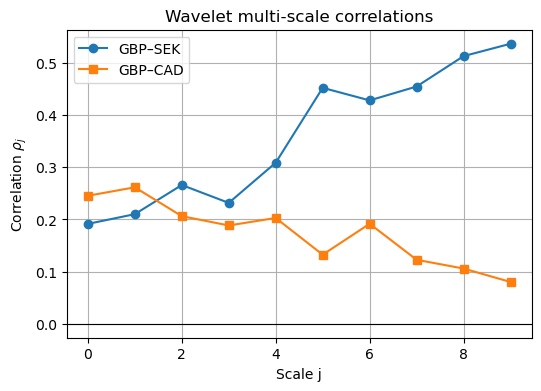

In [78]:
def correlation1D(c1, c2):
    n = min(len(c1), len(c2))
    c1 = c1[:n]
    c2 = c2[:n]

    cov = covariance1D(c1, c2)
    var1 = np.mean((c1 - np.mean(c1))**2)
    var2 = np.mean((c2 - np.mean(c2))**2)

    return cov / np.sqrt(var1 * var2)
def correlationMultiScale(C1, C2):
    n = min(len(C1), len(C2))
    rho = []

    for j in range(n):
        rho.append(correlation1D(C1[j], C2[j]))

    return np.array(rho)

rho_gbp_sek = correlationMultiScale(C_gbp, C_sek)
rho_gbp_cad = correlationMultiScale(C_gbp, C_cad)

#Parceque pour les J trop important il y a pas assez d'élément ça diverge
valid_j = [j for j in range(len(C_gbp)) if len(C_gbp[j]) >= 20]

rho_gbp_sek = rho_gbp_sek[valid_j]
rho_gbp_cad = rho_gbp_cad[valid_j]

plt.figure(figsize=(6,4))
plt.plot(rho_gbp_sek, 'o-', label="GBP–SEK")
plt.plot(rho_gbp_cad, 's-', label="GBP–CAD")

plt.axhline(0, color='k', lw=0.8)
plt.xlabel("Scale j")
plt.ylabel(r"Correlation $\rho_j$")
plt.title("Wavelet multi-scale correlations")
plt.grid(True)
plt.legend()
plt.show()


**b – Calculate the Hurst exponent of GBPEUR, SEKEUR, and CADEUR. Determine their annualized volatility using the daily volatility and Hurst exponents.**

In [79]:
def ComputeM2(df):
    return ((df["mean"]- df["mean"].shift(1)) * (df["mean"] - df["mean"].shift(1) )).mean()

def ComputeM2_prime(df):
    m2_prime = 0.0
        
    for i in range (1, (len(df)-1) // 2 + 1):
        m2_prime += (df["mean"].iloc[2*i] - df["mean"].iloc[2*i-2]) * (df["mean"].iloc[2*i] - df["mean"].iloc[2*i-2])
    m2_prime /= (len(df)-1) // 2
    
    return m2_prime

def ComputeH_hat(df):
    computeMean(df)
    m2_prime = ComputeM2_prime(df)
    m2 = ComputeM2(df)
    return np.log2(m2_prime/m2) / 2

print("Hurst exponent for GBPEUR :", ComputeH_hat(df_gbp))
print("Hurst exponent for SEKEUR :", ComputeH_hat(df_sek))
print("Hurst exponent for CADEUR :", ComputeH_hat(df_cad))

Hurst exponent for GBPEUR : 0.6876414933776451
Hurst exponent for SEKEUR : 0.6797179393979496
Hurst exponent for CADEUR : 0.6803939079960727


In [80]:
def ComputeVolAnnualised(df):
    H = ComputeH_hat(df)
    ComputeReturn(df)
    return np.std(df["return"], ddof=1) * ((252*96)**H)

print("Annualised Volatility GBP :", ComputeVolAnnualised(df_gbp))
print("Annualised Volatility SEK :", ComputeVolAnnualised(df_sek))
print("Annualised Volatility CAD :", ComputeVolAnnualised(df_cad))

Annualised Volatility GBP : 0.6442593225224157
Annualised Volatility SEK : 0.3121755145515661
Annualised Volatility CAD : 0.4862993913261667
